In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

from tqdm import tqdm
from scipy.optimize import minimize

import lightkurve as lk
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.jplhorizons import Horizons

from jorbit.observation import Observations
from jorbit.utils.states import SystemState
from jorbit.ephemeris import Ephemeris
from jorbit.accelerations import create_newtonian_ephemeris_acceleration_func
from jorbit.integrators import ias15_evolve, initialize_ias15_integrator_state
from jorbit.astrometry.sky_projection import on_sky, sky_sep
from jorbit.astrometry.transformations import (
    elements_to_cartesian,
    cartesian_to_elements,
)

In [4]:
def get_orbit_shifts(tpf_file, helio_rs, eccs, nus, Omegas):
    tpf = lk.TessTargetPixelFile(tpf_file)

    central_coord = tpf.wcs.pixel_to_world(128, 128)  # all cutouts are 256x256

    sector_times = jnp.arange(tpf.time[0].tdb.jd, tpf.time[-1].tdb.jd + 1 / 24, 1 / 24)

    obs = Observations(
        observed_coordinates=[
            central_coord for i in range(sector_times.size)
        ],  # fake, just give the central pix
        times=jnp.array(sector_times),
        observatories="@-95",  # code for TESS
        astrometric_uncertainties=1 * u.arcsec,  # doesn't matter
        verbose=True,
    )

    eph = Ephemeris(
        earliest_time=Time("2016-01-01 00:00"),
        latest_time=Time("2026-01-01 00:00"),
        ssos="default planets",
    )
    acc_func = create_newtonian_ephemeris_acceleration_func(eph.processor)

    @jax.jit
    def best_orb(variable_params, fixed_params, target_ra, target_dec, observer_pos):
        x, v = elements_to_cartesian(**fixed_params, **variable_params)
        state = SystemState(
            positions=x,
            velocities=v,
            log_gms=jnp.array([0.0]),
            time=0.0,
            acceleration_func_kwargs=None,
        )
        calc_ra, calc_dec = on_sky(state, acc_func, observer_pos)

        return sky_sep(calc_ra, calc_dec, target_ra, target_dec)[0]

    def produce_valid_orbits(
        helio_rs, eccs, nus, Omegas, target_ra, target_dec, observer_pos
    ):

        def scipy_objective(x, fixed, target_ra, target_dec, observer_pos):
            return best_orb(
                {"omega": jnp.array([x[0]]), "inc": jnp.array([x[1]])},
                fixed,
                target_ra,
                target_dec,
                observer_pos,
            )

        def scipy_gradient(x, fixed, target_ra, target_dec, observer_pos):
            g = jax.jacfwd(best_orb, argnums=0)(
                {"omega": jnp.array([x[0]]), "inc": jnp.array([x[1]])},
                fixed,
                target_ra,
                target_dec,
                observer_pos,
            )
            return jnp.array([g["omega"][0], g["inc"][0]])

        fixed_params = []
        for r in helio_rs:
            for e in eccs:
                for nu in nus:
                    for Omega in Omegas:
                        semi = r / (1 - e**2) * (1 + e * jnp.cos(nu))
                        fixed_params.append(
                            {
                                "a": semi,
                                "ecc": jnp.array([e]),
                                "nu": jnp.array([nu]),
                                "Omega": jnp.array([Omega]),
                            }
                        )

        valid_orbits = []
        for fixed in tqdm(fixed_params, desc="{solving for valid orbits}"):
            res = minimize(
                scipy_objective,
                [20.0, 120.0],
                jac=scipy_gradient,
                method="BFGS",
                args=(fixed, target_ra, target_dec, observer_pos),
                # options={"disp": True},
            )
            if res.fun < 10.0:
                el = {
                    "a": fixed["a"],
                    "ecc": fixed["ecc"],
                    "inc": jnp.array([res.x[1]]),
                    "Omega": fixed["Omega"],
                    "omega": jnp.array([res.x[0]]),
                    "nu": fixed["nu"],
                }
                valid_orbits.append((el, res.fun))

        return valid_orbits

    def valid_cartesian():
        orbs = produce_valid_orbits(
            helio_rs=helio_rs,
            eccs=eccs,
            nus=nus,
            Omegas=Omegas,
            target_ra=central_coord.ra.rad,
            target_dec=central_coord.dec.rad,
            observer_pos=obs.observer_positions[
                0
            ],  # looking at the start of the sector
        )

        xs, vs = [], []
        for o in orbs:
            x, v = elements_to_cartesian(**o[0])
            xs.append(x[0])
            vs.append(v[0])
        xs = jnp.array(xs)[:, None, :]
        vs = jnp.array(vs)[:, None, :]
        return orbs, xs, vs

    orbs, xs, vs = valid_cartesian()

    def sector_astrometry(x, v, observer_positions):
        def _sector_astrometry(x, v, observer_positions):
            state = SystemState(
                positions=x,
                velocities=v,
                log_gms=jnp.array([-jnp.inf]),
                time=sector_times[0],
                acceleration_func_kwargs=None,
            )

            new_positions, new_velocities, state1, new_integrator_state = ias15_evolve(
                initial_system_state=state,
                acceleration_func=acc_func,
                times=sector_times,
                initial_integrator_state=initialize_ias15_integrator_state(
                    acc_func(state)
                ),
                n_steps=3,
            )

            # this is silly, but I haven't fixed the tracer acceleration bug yet
            def tmp(x, v, t, obs_pos):
                state = SystemState(
                    positions=x,
                    velocities=v,
                    log_gms=jnp.ones(x.shape[0]) * -jnp.inf,
                    time=t,
                    acceleration_func_kwargs=None,
                )
                return on_sky(state, acc_func, obs_pos)

            ras, decs = jax.vmap(tmp)(
                new_positions, new_velocities, sector_times, observer_positions
            )
            return ras, decs

            return new_positions, new_velocities

        # surprisingly faster than vmap
        ras, decs = [], []
        for i in tqdm(range(xs.shape[0]), desc="{calculating astrometry}"):
            ra, dec = _sector_astrometry(xs[i], vs[i], obs.observer_positions)
            ras.append(ra)
            decs.append(dec)
        ras = jnp.array(ras)[..., 0]
        decs = jnp.array(decs)[..., 0]

        coords = []
        Rows, Cols = [], []
        for r, d in zip(ras, decs):
            c = SkyCoord(ra=r * u.rad, dec=d * u.rad)
            row, col = tpf.wcs.world_to_array_index(c)
            coords.append(c)
            Rows.append(row)
            Cols.append(col)

        return coords, Rows, Cols

    coords, rows, cols = sector_astrometry(xs, vs, obs.observer_positions)

    return orbs, coords, rows, cols

In [13]:
200 * 50

10000

In [ ]:
tpf_file = "../cam_1_ccd_1_ymin_384_ymax_640_xmin_1324_xmax_1580.fits"

l = -1
helio_rs = jnp.concatenate((jnp.arange(30.0, 50, 2), jnp.arange(50, 100.0, 10)))[:l]
eccs = jnp.arange(0.0, 0.9, 0.1)[:l]
nus = jnp.arange(0, 360.0, 40)[:l]
Omegas = jnp.arange(0, 360.0, 40)[:l]


orbs, coords, rows, cols = get_orbit_shifts(tpf_file, helio_rs, eccs, nus, Omegas)

with open(orb_file, "wb") as f:
    pickle.dump((orbs, coords, rows, cols), f)

{solving for valid orbits}:   2%|▏         | 128/7168 [00:44<40:47,  2.88it/s] 


KeyboardInterrupt: 

In [12]:
jnp.arange(0, 360.0, 40)

Array([  0.,  40.,  80., 120., 160., 200., 240., 280., 320.], dtype=float64)

[(0.0, 256.0), (0.0, 256.0), None]

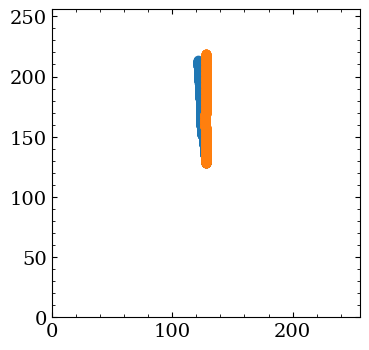

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(cols[0], rows[0], "o")
ax.plot(cols[-1], rows[-1], "o")
ax.set(xlim=(0, 256), ylim=(0, 256), aspect="equal")

In [28]:
tpf.wcs.world_to_array_index(c)

([128,
  128,
  128,
  128,
  128,
  128,
  129,
  129,
  129,
  129,
  129,
  129,
  129,
  129,
  129,
  129,
  130,
  130,
  130,
  130,
  130,
  130,
  130,
  130,
  130,
  130,
  130,
  131,
  131,
  131,
  131,
  131,
  131,
  131,
  131,
  131,
  131,
  132,
  132,
  132,
  132,
  132,
  132,
  132,
  132,
  132,
  132,
  133,
  133,
  133,
  133,
  133,
  133,
  133,
  133,
  133,
  134,
  134,
  134,
  134,
  134,
  134,
  134,
  134,
  134,
  135,
  135,
  135,
  135,
  135,
  135,
  135,
  135,
  135,
  135,
  136,
  136,
  136,
  136,
  136,
  136,
  136,
  136,
  137,
  137,
  137,
  137,
  137,
  137,
  137,
  137,
  137,
  138,
  138,
  138,
  138,
  138,
  138,
  138,
  138,
  138,
  139,
  139,
  139,
  139,
  139,
  139,
  139,
  139,
  140,
  140,
  140,
  140,
  140,
  140,
  140,
  140,
  141,
  141,
  141,
  141,
  141,
  141,
  141,
  141,
  142,
  142,
  142,
  142,
  142,
  142,
  142,
  142,
  143,
  143,
  143,
  143,
  143,
  143,
  143,
  143,
  144,
  144,